# Neural Style Transfer with VGG19

This notebook illustrates the use of Neural Style Transfer for artwork generation, using the VGG19 model pretrained on the [ImageNet](http://www.image-net.org/) dataset. Neural Style Transfer essentially involves generating a styled image of a content image, transfering style properties off some style image.
The original ideas of Neural Style Transfer were first presented in this [paper](https://arxiv.org/abs/1508.06576).

### Import Libraries

In [3]:
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

### Load Content and Style Images

In [4]:
MAX_WIDTH = 256

In [5]:
content_img_path = './Contents/Geoff Hinton.jpg'
content_img = Image.open(content_img_path)

In [6]:
style_img_path = './Styles/Wavy.jpg'
style_img = Image.open(style_img_path)

In [7]:
def get_content_style_img_arrays(content_img, style_img, WIDTH, HEIGHT):
    content_img = content_img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
    style_img = style_img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
    content_img = content_img.convert('RGB')
    style_img = style_img.convert('RGB')
    content_img_array = np.asarray(content_img, dtype=np.float64)[:, :, 0:3]
    style_img_array = np.asarray(style_img, dtype=np.float64)[:, :, 0:3]
    return content_img_array, style_img_array

In [8]:
content_width, content_height = content_img.size
if content_width > MAX_WIDTH:
    WIDTH = MAX_WIDTH
    HEIGHT = int(content_height * MAX_WIDTH / content_width)
else:
    WIDTH = content_width
    HEIGHT = content_height
content_img_array, style_img_array = get_content_style_img_arrays(content_img, style_img, WIDTH, HEIGHT)

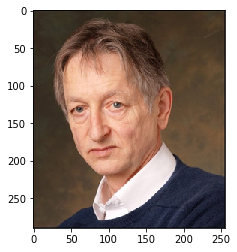

In [9]:
# Preview Content Image
plt.imshow(content_img_array / 255)

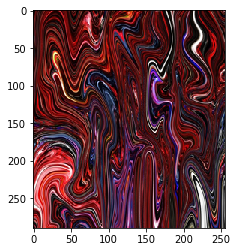

In [10]:
# Preview Style Image
plt.imshow(style_img_array / 255)

### Load VGG model

In [11]:
vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg_model.trainable = False
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Define Content and Style layers

In [12]:
CONTENT_LAYERS = ['block2_conv1', 'block3_conv1']
STYLE_LAYERS = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

### Define function to retrieve VGG model layer activations

In [13]:
def get_layer_outputs(layer_names, input_data):
    intermediate_layer_model = tf.keras.Model(inputs=[vgg_model.input], 
          outputs=[vgg_model.get_layer(layer_name).output for layer_name in layer_names])
    return intermediate_layer_model(input_data)

### Define function to get the Gram matrix for an input image

In [14]:
def gram_matrix(input_tensor):
    assert tf.rank(input_tensor) == 3
    channels = tf.shape(input_tensor)[2]
    assert channels >= 2
    height = tf.shape(input_tensor)[0]
    width = tf.shape(input_tensor)[1]
    input_tensor_flattened = tf.reshape(input_tensor, [height * width, channels])
    return tf.matmul(tf.transpose(input_tensor_flattened), input_tensor_flattened)

### Establish Content and Style targets

In [ ]:
content_img_targets = {}
content_img_preprocessed = tf.keras.applications.vgg19.preprocess_input(
    content_img_array.reshape((1, HEIGHT, WIDTH, 3)))
for i, output in enumerate(get_layer_outputs(CONTENT_LAYERS, content_img_preprocessed)):
    content_img_targets[CONTENT_LAYERS[i]] = output[0]

style_img_targets = {}
style_img_preprocessed = tf.keras.applications.vgg19.preprocess_input(
    style_img_array.reshape((1, HEIGHT, WIDTH, 3)))
for i, output in enumerate(get_layer_outputs(STYLE_LAYERS, style_img_preprocessed)):
    style_img_targets[STYLE_LAYERS[i]] = gram_matrix(output[0])

### Define Content Cost Function

In [16]:
def compute_content_cost(generated_img, content_cost_weight):
    content_cost = tf.Variable(0.0)
    generated_img_preprocessed = tf.keras.applications.vgg19.preprocess_input(
        tf.reshape(generated_img, [1, HEIGHT, WIDTH, 3]))
    for i, output in enumerate(get_layer_outputs(CONTENT_LAYERS, generated_img_preprocessed)):
        content_cost = tf.math.add(content_cost, tf.math.reduce_mean(
            tf.math.squared_difference(content_img_targets[CONTENT_LAYERS[i]], output)))
    return tf.math.multiply(content_cost, tf.constant(content_cost_weight / len(CONTENT_LAYERS)))

### Define Style Cost Function

In [17]:
def compute_style_cost(generated_img, style_cost_weight):
    style_cost = tf.Variable(0.0)
    generated_img_preprocessed = tf.keras.applications.vgg19.preprocess_input(
        tf.reshape(generated_img, [1, HEIGHT, WIDTH, 3]))
    for i, output in enumerate(get_layer_outputs(STYLE_LAYERS, generated_img_preprocessed)):
        style_cost = tf.math.add(style_cost, tf.math.reduce_mean(tf.math.squared_difference(
            style_img_targets[STYLE_LAYERS[i]], gram_matrix(output[0]))))
    return tf.math.multiply(style_cost, tf.constant(style_cost_weight / len(STYLE_LAYERS)))

### Define Total Cost

In [18]:
def compute_total_cost(generated_img, content_cost_weight=0.6, style_cost_weight=0.4):
    return tf.math.add(compute_content_cost(generated_img, content_cost_weight), 
                       compute_style_cost(generated_img, style_cost_weight))

### Define Optimizer

In [38]:
adam_optimizer = tf.optimizers.Adam(learning_rate=22)

### Define Training loop

In [43]:
def train_step(step, generated_img):
  with tf.GradientTape() as tape:
    loss = compute_total_cost(generated_img, 1.5e4, 4e-9)
    if (step + 1) % 2 == 0 :
        print('Loss at step {} = {}'.format(step + 1, loss.numpy()))
  grad = tape.gradient(loss, generated_img)
  adam_optimizer.apply_gradients([(grad, generated_img)])
  generated_img.assign(generated_img)

In [44]:
generated_img = tf.Variable(np.random.random(content_img_array.shape), trainable=True)
for i in range(50):
    train_step(i, generated_img)

Loss at step 2 = 2942563584.0
Loss at step 4 = 2737103104.0
Loss at step 6 = 2418167040.0
Loss at step 8 = 1964639360.0
Loss at step 10 = 1684273280.0
Loss at step 12 = 1514798080.0
Loss at step 14 = 1391193088.0
Loss at step 16 = 1293144320.0
Loss at step 18 = 1211625088.0
Loss at step 20 = 1148327040.0
Loss at step 22 = 1099245056.0
Loss at step 24 = 1070006336.0
Loss at step 26 = 1083447936.0
Loss at step 28 = 1153809408.0
Loss at step 30 = 1101866112.0
Loss at step 32 = 1036292352.0
Loss at step 34 = 987408320.0
Loss at step 36 = 955337728.0
Loss at step 38 = 932465856.0
Loss at step 40 = 916529920.0
Loss at step 42 = 914179008.0
Loss at step 44 = 913956736.0
Loss at step 46 = 910729344.0
Loss at step 48 = 895865280.0
Loss at step 50 = 880161472.0


### Save generated image to file

In [45]:
generated_img_array = generated_img.numpy()
generated_img_array = np.maximum(generated_img_array, 0)
generated_img_array = np.minimum(generated_img_array, 255)
generated_img_array = np.uint8(generated_img_array)
generated_img_PIL = Image.fromarray(generated_img_array)

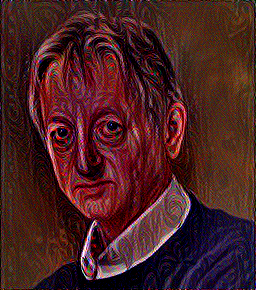

In [46]:
generated_img_PIL

In [47]:
generated_img_PIL.save('./Generated/styled.jpg')